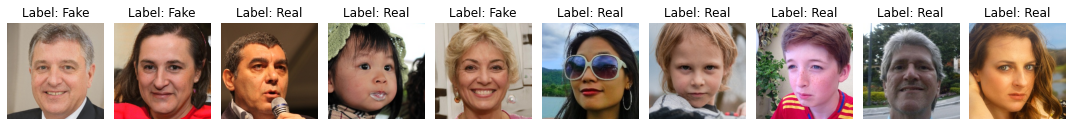

In [9]:
%matplotlib inline
import os
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Path to dataset
path = "/data/archive/real_vs_fake/real-vs-fake"
size = (256, 256)  # Image size


# Transforms for training and validation/test
# Transforms for training and validation/test
train_transform = transforms.Compose([
    transforms.Resize(size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize with mean and std
])

test_transform = transforms.Compose([
    transforms.Resize(size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize with mean and std
])


# Load datasets
train_dataset = ImageFolder(os.path.join(path, 'train'), transform=train_transform)
val_dataset = ImageFolder(os.path.join(path, 'valid'), transform=test_transform)
test_dataset = ImageFolder(os.path.join(path, 'test'), transform=test_transform)

# Dataloaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# Fetch a batch of images and labels
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Function to display images in a grid
def display_images(images, labels, class_names, num_images=10):
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        # Convert the tensor image to a NumPy array for display
        img = images[i].permute(1, 2, 0).cpu().numpy()
        img = (img * 0.5 + 0.5)  # Denormalize
        plt.imshow(img)
        plt.title(f"Label: {class_names[labels[i].item()]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Class names mapping
class_names = {0: 'Fake', 1: 'Real'}

# Display 10 images
display_images(images, labels, class_names, num_images=10)


In [10]:
import torch.nn as nn
from torchvision.models import densenet121

# Load a pre-trained DenseNet121 model
model = densenet121(pretrained=True)

# Modify the classifier for binary classification
num_ftrs = model.classifier.in_features
model.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(0.5),  # Increased dropout for stronger regularization
    nn.BatchNorm1d(512),  # BatchNorm for stability
    nn.Linear(512, 1),
    nn.Sigmoid()
)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [13]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau


# Optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Scheduler for learning rate reduction
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=3, verbose=True)

# Loss function
criterion = nn.BCELoss()


In [20]:
from torchvision.models import resnet50

# Load a pre-trained ResNet model
resnet_model = resnet50(pretrained=True)

# Modify the classifier for binary classification
num_ftrs = resnet_model.fc.in_features
resnet_model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.BatchNorm1d(512),
    nn.Linear(512, 1),
    nn.Sigmoid()
)

# Move ResNet model to GPU
resnet_model = resnet_model.to(device)


/home1/09883/humerasabir/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home1/09883/humerasabir/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home1/09883/humerasabir/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 115MB/s] 


In [21]:
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  # Conv Layer 1
            nn.BatchNorm2d(32),                                   # Batch Norm 1
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                # Pooling Layer 1
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), # Conv Layer 2
            nn.BatchNorm2d(64),                                   # Batch Norm 2
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                # Pooling Layer 2
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),# Conv Layer 3
            nn.BatchNorm2d(128),                                  # Batch Norm 3
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                # Pooling Layer 3
        )
        
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),                         # Global Average Pooling
            nn.Flatten(),
            nn.Linear(128, 512),                                 # Fully Connected Layer 1
            nn.ReLU(),
            nn.Dropout(0.5),                                     # Dropout
            nn.Linear(512, 1),                                   # Fully Connected Layer 2
            nn.Sigmoid()                                         # Binary Classification
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x



# Initialize the custom model
custom_model = CustomCNN().to(device)


In [14]:
from tqdm.notebook import tqdm


In [27]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs=10, early_stopping_patience=None):
    best_val_loss = float('inf')
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    early_stopping_counter = 0  # Counter to track epochs without improvement

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        
        # Training phase
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0
        
        # Add tqdm progress bar for training
        with tqdm(total=len(train_loader), desc="Training", unit="batch") as pbar:
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device).float()
                optimizer.zero_grad()
                outputs = model(inputs).squeeze()
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item() * inputs.size(0)
                preds = (outputs > 0.5).float()
                correct += (preds == labels).sum().item()
                total += labels.size(0)
                
                # Update tqdm progress bar
                pbar.set_postfix({"Batch Loss": f"{loss.item():.4f}"})
                pbar.update(1)
        
        train_loss /= len(train_loader.dataset)
        train_acc = correct / total
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with tqdm(total=len(val_loader), desc="Validation", unit="batch") as pbar:
            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device).float()
                    outputs = model(inputs).squeeze()
                    loss = criterion(outputs, labels)
                    val_loss += loss.item() * inputs.size(0)
                    preds = (outputs > 0.5).float()
                    correct += (preds == labels).sum().item()
                    total += labels.size(0)
                    
                    pbar.set_postfix({"Batch Loss": f"{loss.item():.4f}"})
                    pbar.update(1)
        
        val_loss /= len(val_loader.dataset)
        val_acc = correct / total
        
        # Update the learning rate scheduler
        scheduler.step(val_loss)
        
        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'custom-best_model.pth')
            early_stopping_counter = 0  # Reset counter when validation improves
        else:
            early_stopping_counter += 1
        
        # Stop training if early stopping is triggered
        if early_stopping_patience and early_stopping_counter >= early_stopping_patience:
            print("Early stopping triggered.")
            break
        
        # Logging
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    return history


In [16]:

 # Train the model
history = train_model(model, train_loader,  val_loader, criterion, optimizer,scheduler, device)


Epoch 1/10


Training:   0%|          | 0/1563 [00:00<?, ?batch/s]

Validation:   0%|          | 0/313 [00:00<?, ?batch/s]

Train Loss: 0.1362, Train Acc: 0.9439 | Val Loss: 0.1316, Val Acc: 0.9505

Epoch 2/10


Training:   0%|          | 0/1563 [00:00<?, ?batch/s]

Validation:   0%|          | 0/313 [00:00<?, ?batch/s]

Train Loss: 0.0686, Train Acc: 0.9740 | Val Loss: 0.1392, Val Acc: 0.9408

Epoch 3/10


Training:   0%|          | 0/1563 [00:00<?, ?batch/s]

Validation:   0%|          | 0/313 [00:00<?, ?batch/s]

Train Loss: 0.0574, Train Acc: 0.9789 | Val Loss: 0.2969, Val Acc: 0.9074

Epoch 4/10


Training:   0%|          | 0/1563 [00:00<?, ?batch/s]

Validation:   0%|          | 0/313 [00:00<?, ?batch/s]

Train Loss: 0.0516, Train Acc: 0.9804 | Val Loss: 0.0884, Val Acc: 0.9673

Epoch 5/10


Training:   0%|          | 0/1563 [00:00<?, ?batch/s]

Validation:   0%|          | 0/313 [00:00<?, ?batch/s]

Train Loss: 0.0481, Train Acc: 0.9827 | Val Loss: 0.0618, Val Acc: 0.9762

Epoch 6/10


Training:   0%|          | 0/1563 [00:00<?, ?batch/s]

Validation:   0%|          | 0/313 [00:00<?, ?batch/s]

Train Loss: 0.0452, Train Acc: 0.9832 | Val Loss: 0.3372, Val Acc: 0.8881

Epoch 7/10


Training:   0%|          | 0/1563 [00:00<?, ?batch/s]

Validation:   0%|          | 0/313 [00:00<?, ?batch/s]

Train Loss: 0.0412, Train Acc: 0.9851 | Val Loss: 0.0441, Val Acc: 0.9840

Epoch 8/10


Training:   0%|          | 0/1563 [00:00<?, ?batch/s]

Validation:   0%|          | 0/313 [00:00<?, ?batch/s]

Train Loss: 0.0410, Train Acc: 0.9851 | Val Loss: 0.1604, Val Acc: 0.9412

Epoch 9/10


Training:   0%|          | 0/1563 [00:00<?, ?batch/s]

Validation:   0%|          | 0/313 [00:00<?, ?batch/s]

Train Loss: 0.0385, Train Acc: 0.9857 | Val Loss: 0.1263, Val Acc: 0.9521

Epoch 10/10


Training:   0%|          | 0/1563 [00:00<?, ?batch/s]

Validation:   0%|          | 0/313 [00:00<?, ?batch/s]

Train Loss: 0.0383, Train Acc: 0.9859 | Val Loss: 0.0322, Val Acc: 0.9884


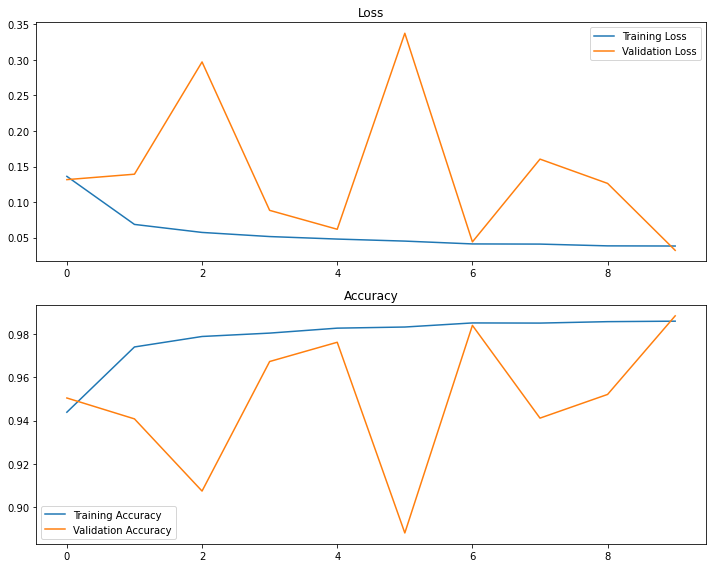

In [17]:
import matplotlib.pyplot as plt

# Plot training and validation loss and accuracy
def plot_history(history):
    epochs = len(history['train_loss'])
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

    ax1.plot(range(epochs), history['train_loss'], label='Training Loss')
    ax1.plot(range(epochs), history['val_loss'], label='Validation Loss')
    ax1.set_title('Loss')
    ax1.legend()

    ax2.plot(range(epochs), history['train_acc'], label='Training Accuracy')
    ax2.plot(range(epochs), history['val_acc'], label='Validation Accuracy')
    ax2.set_title('Accuracy')
    ax2.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)


In [23]:

# Train ResNet
resnet_optimizer = torch.optim.Adam(resnet_model.parameters(), lr=0.001, weight_decay=1e-4)
resnet_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(resnet_optimizer, mode='min', factor=0.2, patience=3, verbose=True)
resnet_history = train_model(resnet_model, train_loader, val_loader, criterion, resnet_optimizer, resnet_scheduler, device, epochs=10)




Epoch 1/10


/home1/09883/humerasabir/.local/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Training:   0%|          | 0/1563 [00:00<?, ?batch/s]

Validation:   0%|          | 0/313 [00:00<?, ?batch/s]

Train Loss: 0.1892, Train Acc: 0.9204 | Val Loss: 0.2011, Val Acc: 0.9251

Epoch 2/10


Training:   0%|          | 0/1563 [00:00<?, ?batch/s]

Validation:   0%|          | 0/313 [00:00<?, ?batch/s]

Train Loss: 0.1006, Train Acc: 0.9614 | Val Loss: 0.2489, Val Acc: 0.9080

Epoch 3/10


Training:   0%|          | 0/1563 [00:00<?, ?batch/s]

Validation:   0%|          | 0/313 [00:00<?, ?batch/s]

Train Loss: 0.0795, Train Acc: 0.9706 | Val Loss: 0.1145, Val Acc: 0.9533

Epoch 4/10


Training:   0%|          | 0/1563 [00:00<?, ?batch/s]

Validation:   0%|          | 0/313 [00:00<?, ?batch/s]

Train Loss: 0.0707, Train Acc: 0.9737 | Val Loss: 0.3982, Val Acc: 0.8624

Epoch 5/10


Training:   0%|          | 0/1563 [00:00<?, ?batch/s]

Validation:   0%|          | 0/313 [00:00<?, ?batch/s]

Train Loss: 0.0624, Train Acc: 0.9768 | Val Loss: 0.0604, Val Acc: 0.9760

Epoch 6/10


Training:   0%|          | 0/1563 [00:00<?, ?batch/s]

Validation:   0%|          | 0/313 [00:00<?, ?batch/s]

Train Loss: 0.0586, Train Acc: 0.9782 | Val Loss: 0.6358, Val Acc: 0.8155

Epoch 7/10


Training:   0%|          | 0/1563 [00:00<?, ?batch/s]

Validation:   0%|          | 0/313 [00:00<?, ?batch/s]

Train Loss: 0.0516, Train Acc: 0.9813 | Val Loss: 0.2284, Val Acc: 0.9146

Epoch 8/10


Training:   0%|          | 0/1563 [00:00<?, ?batch/s]

Validation:   0%|          | 0/313 [00:00<?, ?batch/s]

Train Loss: 0.0483, Train Acc: 0.9825 | Val Loss: 0.1222, Val Acc: 0.9556

Epoch 9/10


Training:   0%|          | 0/1563 [00:00<?, ?batch/s]

Validation:   0%|          | 0/313 [00:00<?, ?batch/s]

Train Loss: 0.0486, Train Acc: 0.9823 | Val Loss: 0.2631, Val Acc: 0.9129

Epoch 10/10


Training:   0%|          | 0/1563 [00:00<?, ?batch/s]

Validation:   0%|          | 0/313 [00:00<?, ?batch/s]

Train Loss: 0.0152, Train Acc: 0.9951 | Val Loss: 0.0124, Val Acc: 0.9960


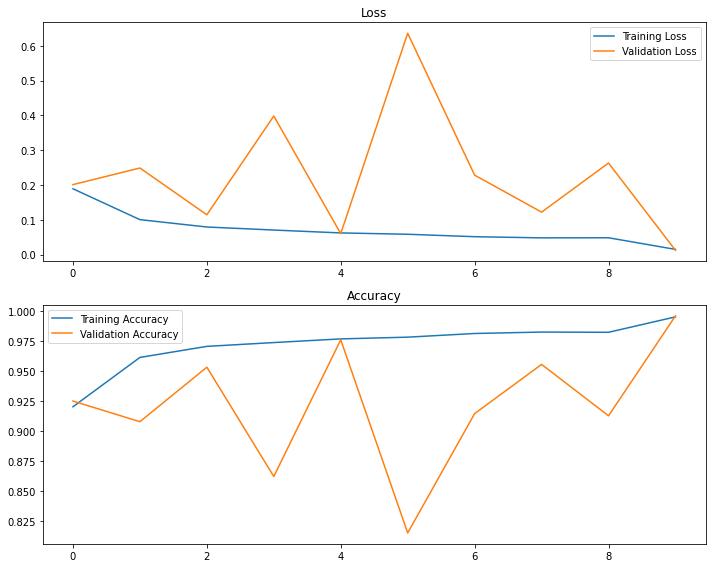

In [24]:
plot_history(resnet_history)

/tmp/ipykernel_2259691/1528389195.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


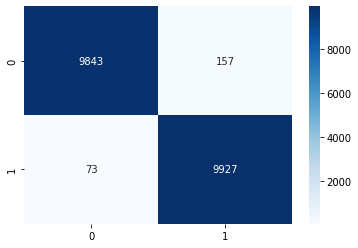

ROC-AUC Score: 0.9992756199999999
AP Score: 0.9992709625189481

Classification Report
               precision    recall  f1-score   support

         0.0       0.99      0.98      0.99     10000
         1.0       0.98      0.99      0.99     10000

    accuracy                           0.99     20000
   macro avg       0.99      0.99      0.99     20000
weighted avg       0.99      0.99      0.99     20000



In [19]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score
import seaborn as sns
import numpy as np

# Load the best model for DenseNet
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

# Evaluate on test set
all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device).float()
        outputs = model(inputs).squeeze()
        preds = (outputs > 0.5).float()
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(outputs.cpu().numpy())

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, (np.array(all_preds) > 0.5).astype(int))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.show()

# Metrics
print("ROC-AUC Score:", roc_auc_score(all_labels, all_preds))
print("AP Score:", average_precision_score(all_labels, all_preds))
print('\nClassification Report\n', classification_report(all_labels, (np.array(all_preds) > 0.5).astype(int)))


/tmp/ipykernel_2259691/862357510.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet_model.load_state_dict(torch.load('resnet-best_model.pth'))


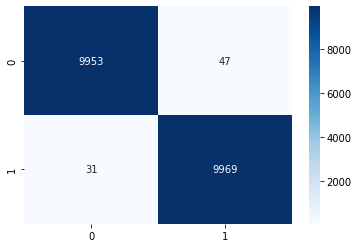

ROC-AUC Score: 0.9998410500000001
AP Score: 0.9998795239395823

Classification Report
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     10000
         1.0       1.00      1.00      1.00     10000

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000



In [26]:

# Load the best model for DenseNet
resnet_model.load_state_dict(torch.load('resnet-best_model.pth'))
resnet_model.eval()

# Evaluate on test set
all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device).float()
        outputs = resnet_model(inputs).squeeze()
        preds = (outputs > 0.5).float()
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(outputs.cpu().numpy())

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, (np.array(all_preds) > 0.5).astype(int))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.show()

# Metrics
print("ROC-AUC Score:", roc_auc_score(all_labels, all_preds))
print("AP Score:", average_precision_score(all_labels, all_preds))
print('\nClassification Report\n', classification_report(all_labels, (np.array(all_preds) > 0.5).astype(int)))


In [28]:
# Train Custom Model
custom_optimizer = torch.optim.Adam(custom_model.parameters(), lr=0.001, weight_decay=1e-4)
custom_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(custom_optimizer, mode='min', factor=0.2, patience=3, verbose=True)
custom_history = train_model(custom_model, train_loader, val_loader, criterion, custom_optimizer, custom_scheduler, device, epochs=30)



Epoch 1/30


/home1/09883/humerasabir/.local/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Training:   0%|          | 0/1563 [00:00<?, ?batch/s]

Validation:   0%|          | 0/313 [00:00<?, ?batch/s]

Train Loss: 49.9233, Train Acc: 0.5000 | Val Loss: 50.0000, Val Acc: 0.5000

Epoch 2/30


Training:   0%|          | 0/1563 [00:00<?, ?batch/s]

Validation:   0%|          | 0/313 [00:00<?, ?batch/s]

Train Loss: 50.0038, Train Acc: 0.4990 | Val Loss: 50.0000, Val Acc: 0.5000

Epoch 3/30


Training:   0%|          | 0/1563 [00:00<?, ?batch/s]

Validation:   0%|          | 0/313 [00:00<?, ?batch/s]

Train Loss: 49.9934, Train Acc: 0.4999 | Val Loss: 50.0000, Val Acc: 0.5000

Epoch 4/30


Training:   0%|          | 0/1563 [00:00<?, ?batch/s]

Validation:   0%|          | 0/313 [00:00<?, ?batch/s]

Train Loss: 49.9812, Train Acc: 0.5000 | Val Loss: 50.0000, Val Acc: 0.5000

Epoch 5/30


Training:   0%|          | 0/1563 [00:00<?, ?batch/s]

Validation:   0%|          | 0/313 [00:00<?, ?batch/s]

Train Loss: 49.9979, Train Acc: 0.5000 | Val Loss: 50.0000, Val Acc: 0.5000

Epoch 6/30


Training:   0%|          | 0/1563 [00:00<?, ?batch/s]

Validation:   0%|          | 0/313 [00:00<?, ?batch/s]

Train Loss: 50.0000, Train Acc: 0.5000 | Val Loss: 50.0000, Val Acc: 0.5000

Epoch 7/30


Training:   0%|          | 0/1563 [00:00<?, ?batch/s]

Validation:   0%|          | 0/313 [00:00<?, ?batch/s]

Train Loss: 49.9958, Train Acc: 0.5000 | Val Loss: 50.0000, Val Acc: 0.5000

Epoch 8/30


Training:   0%|          | 0/1563 [00:00<?, ?batch/s]

Validation:   0%|          | 0/313 [00:00<?, ?batch/s]

Train Loss: 24.2742, Train Acc: 0.5965 | Val Loss: 0.5370, Val Acc: 0.7345

Epoch 9/30


Training:   0%|          | 0/1563 [00:00<?, ?batch/s]

Validation:   0%|          | 0/313 [00:00<?, ?batch/s]

Train Loss: 0.4983, Train Acc: 0.7587 | Val Loss: 0.4373, Val Acc: 0.7995

Epoch 10/30


Training:   0%|          | 0/1563 [00:00<?, ?batch/s]

Validation:   0%|          | 0/313 [00:00<?, ?batch/s]

Train Loss: 0.4187, Train Acc: 0.8101 | Val Loss: 0.3708, Val Acc: 0.8382

Epoch 11/30


Training:   0%|          | 0/1563 [00:00<?, ?batch/s]

Validation:   0%|          | 0/313 [00:00<?, ?batch/s]

Train Loss: 0.3526, Train Acc: 0.8456 | Val Loss: 0.3035, Val Acc: 0.8730

Epoch 12/30


Training:   0%|          | 0/1563 [00:00<?, ?batch/s]

Validation:   0%|          | 0/313 [00:00<?, ?batch/s]

Train Loss: 0.2972, Train Acc: 0.8743 | Val Loss: 0.2623, Val Acc: 0.8894

Epoch 13/30


Training:   0%|          | 0/1563 [00:00<?, ?batch/s]

Validation:   0%|          | 0/313 [00:00<?, ?batch/s]

Train Loss: 0.2510, Train Acc: 0.8982 | Val Loss: 0.2407, Val Acc: 0.9029

Epoch 14/30


Training:   0%|          | 0/1563 [00:00<?, ?batch/s]

Validation:   0%|          | 0/313 [00:00<?, ?batch/s]

Train Loss: 0.2103, Train Acc: 0.9148 | Val Loss: 0.1986, Val Acc: 0.9214

Epoch 15/30


Training:   0%|          | 0/1563 [00:00<?, ?batch/s]

Validation:   0%|          | 0/313 [00:00<?, ?batch/s]

Train Loss: 0.1776, Train Acc: 0.9293 | Val Loss: 0.1667, Val Acc: 0.9333

Epoch 16/30


Training:   0%|          | 0/1563 [00:00<?, ?batch/s]

Validation:   0%|          | 0/313 [00:00<?, ?batch/s]

Train Loss: 0.1501, Train Acc: 0.9422 | Val Loss: 0.1522, Val Acc: 0.9414

Epoch 17/30


Training:   0%|          | 0/1563 [00:00<?, ?batch/s]

Validation:   0%|          | 0/313 [00:00<?, ?batch/s]

Train Loss: 0.1316, Train Acc: 0.9503 | Val Loss: 0.1357, Val Acc: 0.9470

Epoch 18/30


Training:   0%|          | 0/1563 [00:00<?, ?batch/s]

Validation:   0%|          | 0/313 [00:00<?, ?batch/s]

Train Loss: 0.1126, Train Acc: 0.9573 | Val Loss: 0.1226, Val Acc: 0.9540

Epoch 19/30


Training:   0%|          | 0/1563 [00:00<?, ?batch/s]

Validation:   0%|          | 0/313 [00:00<?, ?batch/s]

Train Loss: 0.1013, Train Acc: 0.9625 | Val Loss: 0.1209, Val Acc: 0.9530

Epoch 20/30


Training:   0%|          | 0/1563 [00:00<?, ?batch/s]

Validation:   0%|          | 0/313 [00:00<?, ?batch/s]

Train Loss: 0.0899, Train Acc: 0.9666 | Val Loss: 0.1155, Val Acc: 0.9567

Epoch 21/30


Training:   0%|          | 0/1563 [00:00<?, ?batch/s]

Validation:   0%|          | 0/313 [00:00<?, ?batch/s]

Train Loss: 0.0825, Train Acc: 0.9695 | Val Loss: 0.1071, Val Acc: 0.9595

Epoch 22/30


Training:   0%|          | 0/1563 [00:00<?, ?batch/s]

Validation:   0%|          | 0/313 [00:00<?, ?batch/s]

Train Loss: 0.0746, Train Acc: 0.9729 | Val Loss: 0.0998, Val Acc: 0.9627

Epoch 23/30


Training:   0%|          | 0/1563 [00:00<?, ?batch/s]

Validation:   0%|          | 0/313 [00:00<?, ?batch/s]

Train Loss: 0.0681, Train Acc: 0.9752 | Val Loss: 0.0964, Val Acc: 0.9654

Epoch 24/30


Training:   0%|          | 0/1563 [00:00<?, ?batch/s]

Validation:   0%|          | 0/313 [00:00<?, ?batch/s]

Train Loss: 0.0639, Train Acc: 0.9771 | Val Loss: 0.0976, Val Acc: 0.9654

Epoch 25/30


Training:   0%|          | 0/1563 [00:00<?, ?batch/s]

Validation:   0%|          | 0/313 [00:00<?, ?batch/s]

Train Loss: 0.0608, Train Acc: 0.9782 | Val Loss: 0.0923, Val Acc: 0.9656

Epoch 26/30


Training:   0%|          | 0/1563 [00:00<?, ?batch/s]

Validation:   0%|          | 0/313 [00:00<?, ?batch/s]

Train Loss: 0.0570, Train Acc: 0.9796 | Val Loss: 0.1024, Val Acc: 0.9613

Epoch 27/30


Training:   0%|          | 0/1563 [00:00<?, ?batch/s]

Validation:   0%|          | 0/313 [00:00<?, ?batch/s]

Train Loss: 0.0563, Train Acc: 0.9796 | Val Loss: 0.0871, Val Acc: 0.9686

Epoch 28/30


Training:   0%|          | 0/1563 [00:00<?, ?batch/s]

Validation:   0%|          | 0/313 [00:00<?, ?batch/s]

Train Loss: 0.0539, Train Acc: 0.9809 | Val Loss: 0.0868, Val Acc: 0.9681

Epoch 29/30


Training:   0%|          | 0/1563 [00:00<?, ?batch/s]

Validation:   0%|          | 0/313 [00:00<?, ?batch/s]

Train Loss: 0.0498, Train Acc: 0.9822 | Val Loss: 0.0877, Val Acc: 0.9679

Epoch 30/30


Training:   0%|          | 0/1563 [00:00<?, ?batch/s]

Validation:   0%|          | 0/313 [00:00<?, ?batch/s]

Train Loss: 0.0488, Train Acc: 0.9823 | Val Loss: 0.0874, Val Acc: 0.9677


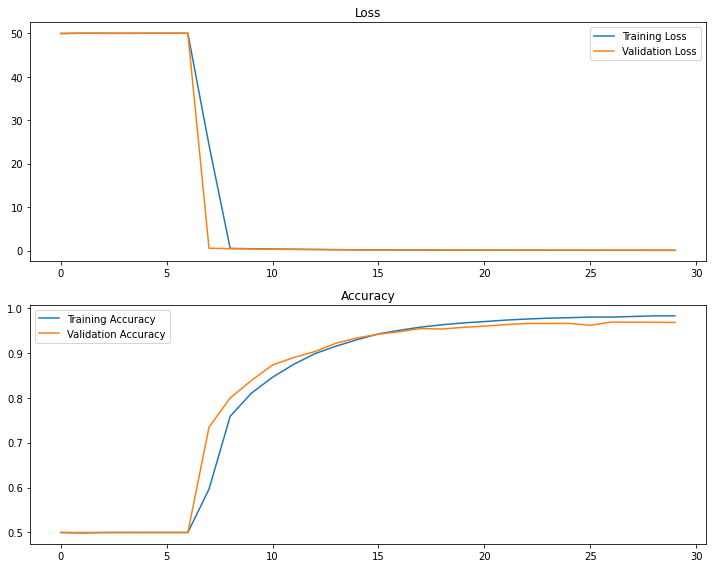

In [29]:
plot_history(custom_history)

/tmp/ipykernel_2259691/2187438550.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  custom_model.load_state_dict(torch.load('custom-best_model.pth'))


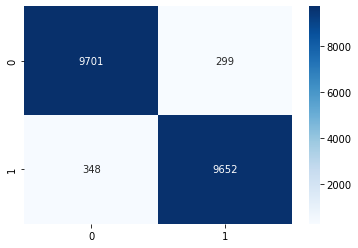

ROC-AUC Score: 0.9951656699999998
AP Score: 0.9948699991474845

Classification Report
               precision    recall  f1-score   support

         0.0       0.97      0.97      0.97     10000
         1.0       0.97      0.97      0.97     10000

    accuracy                           0.97     20000
   macro avg       0.97      0.97      0.97     20000
weighted avg       0.97      0.97      0.97     20000



In [30]:

# Load the best model for DenseNet
custom_model.load_state_dict(torch.load('custom-best_model.pth'))
custom_model.eval()

# Evaluate on test set
all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device).float()
        outputs = custom_model(inputs).squeeze()
        preds = (outputs > 0.5).float()
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(outputs.cpu().numpy())

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, (np.array(all_preds) > 0.5).astype(int))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.show()

# Metrics
print("ROC-AUC Score:", roc_auc_score(all_labels, all_preds))
print("AP Score:", average_precision_score(all_labels, all_preds))
print('\nClassification Report\n', classification_report(all_labels, (np.array(all_preds) > 0.5).astype(int)))


In [31]:
import numpy as np

def majority_voting(models, test_loader, device):
    all_predictions = []  # To store predictions from all models

    for model in models:
        model_predictions = []
        with torch.no_grad():
            for inputs, _ in test_loader:
                inputs = inputs.to(device)
                outputs = model(inputs).squeeze()  # Get predictions
                preds = (outputs > 0.5).float().cpu().numpy()  # Binary predictions
                model_predictions.extend(preds)
        all_predictions.append(model_predictions)

    # Convert predictions to numpy array for majority voting
    all_predictions = np.array(all_predictions)  # Shape: (num_models, num_samples)
    final_predictions = np.mean(all_predictions, axis=0) > 0.5  # Majority voting
    return final_predictions.astype(int)


/tmp/ipykernel_2259691/776826548.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  custom_model.load_state_dict(torch.load('custom-best_model.pth'))
/tmp/ipykernel_2259691

Majority Voting Metrics:
Accuracy: 0.9965
Precision: 0.9948
Recall: 0.9982
F1-Score: 0.9965
ROC-AUC: 0.9965


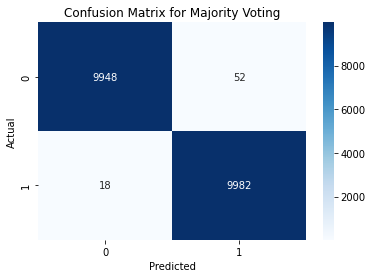

In [34]:
# Load models with saved weights
custom_model.load_state_dict(torch.load('custom-best_model.pth'))
resnet_model.load_state_dict(torch.load('resnet-best_model.pth'))
model.load_state_dict(torch.load('best_model.pth'))

# Set models to evaluation mode
custom_model.eval()
resnet_model.eval()
model.eval()
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load true labels
true_labels = []
for _, labels in test_loader:
    true_labels.extend(labels.numpy())
true_labels = np.array(true_labels)

# Perform majority voting
models = [custom_model, resnet_model, model]
ensemble_predictions = majority_voting(models, test_loader, device)

# Calculate metrics
accuracy = accuracy_score(true_labels, ensemble_predictions)
precision = precision_score(true_labels, ensemble_predictions)
recall = recall_score(true_labels, ensemble_predictions)
f1 = f1_score(true_labels, ensemble_predictions)
roc_auc = roc_auc_score(true_labels, ensemble_predictions)

# Print metrics
print(f"Majority Voting Metrics:\n"
      f"Accuracy: {accuracy:.4f}\n"
      f"Precision: {precision:.4f}\n"
      f"Recall: {recall:.4f}\n"
      f"F1-Score: {f1:.4f}\n"
      f"ROC-AUC: {roc_auc:.4f}")

# Plot confusion matrix
conf_matrix = confusion_matrix(true_labels, ensemble_predictions)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix for Majority Voting")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
